# **Personal Finance Analysis & Prediction Project**

### Author: Cooper Braun

### Class: CPSC-222 Spring 2025

## **1. Introduction**

This project analyzes my personal financial data in relation to my academic schedule at Gonzaga University to identify spending patterns and predict my spending behavior. As a college student with limited income, I believe effective financial management is essential to my success and well-being. Understanding the relationship between my academic life and spending habits can help me budget more effectively and hopefully develop healthier financial habits that will benefit me in the long run.

### Why This Domain Matters to Me

Personal finance management is particularly important for college students like me who are often experiencing financial independence for the first time. The habits formed during these years can impact financial well-being for someones entire life. By analyzing my own spending in relation to my academic schedule, I hope to gain insights that will help me make more informed decisions and potentially identify patterns in my spending that I wasn't aware of.

### Dataset Format and Collection

My dataset consists of two CSV files:

1. Bank Data (`bank_data.csv`): This contains 205 banking transactions spanning September 2024 to April 2025 (7 months). I collected this data by downloading transaction history from my bank's online portal. Each transaction includes date, description, type, amount, and account balance.
2. Academic Calendar (`academic_calendar.csv`): This contains 152 days of academic data for the same time period. I compiled this information from my class's syllabi/Canvas pages and Gonzaga's online academic calendar from their website, manually creating entries for each day marking lecture periods, exam periods, quiz periods, breaks, and weekends.

### Attributes Description

**Bank Data Attributes:**

* _Date_: Transaction date (YYYY-MM-DD format)
* _Description_: Merchant name or transaction description
* _Type_: Transaction type as labeled by the bank (e.g., "Debit Card", "Direct Payment")
* _Amount_: Dollar amount (negative for spending, positive for deposits)
* _Current balance_: Account balance after transaction
* _Status_: Whether the transaction has posted or is pending

**Academic Calendar Attributes:**

* _date_: Calendar date (YYYY-MM-DD format)
* *academic_event_type*: Type of academic day (e.g., "Regular Classes", "Finals Week", "Spring Vacation")
* *class_activity*: Specific activity for that day (e.g., "Lecture", "Exam", "Quiz", "No Class")

### Classification Task

In this project, I am classifying each transaction into one of four spending bins based on the transaction amount:

* Small (Less than $10)
* Medium ($10-$50)
* Large ($50-$100)
* Very Large (More than $100)

My goal is to predict which spending bin a transaction will fall into based on factors like day of the week, academic period type, and transaction category.

### Potential Impacts and Stakeholders

The results of my analysis could have several impacts:

1. _Personal financial planning_: I can better anticipate spending patterns based on my academic schedule and make more informed budgeting decisions.
2. _Student financial literacy_: Other university students could benefit from similar analyses to better understand their own spending behaviors.
3. _University financial support services_: Student financial advisors could use similar approaches to provide personalized guidance to students.
4. _Financial institutions_: Banks and credit unions serving college communities could develop more targeted financial advice and educational resources.

Key stakeholders include:

* Myself as the primary beneficiary of these insights
* Other university students facing similar financial management challenges
* University financial aid and student support services
* Financial institutions serving student populations
* Parents or family members who may be supporting students financially

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from utils import *

In [2]:
# Load raw data
bank_data, academic_data = load_data("bank_data.csv", "academic_calendar.csv")

print(f"I have {bank_data.shape[0]} banking transactions to analyze")
print(f"My academic calendar spans {academic_data.shape[0]} days")

# A few of my banking transactions to show data
print("Here is a peek at a couple of my recent transactions:")
display(bank_data.head(4))

# A look at my academic calendar
print("And here's a snapshot of my academic calendar:")
display(academic_data.head(4))

I have 205 banking transactions to analyze
My academic calendar spans 152 days
Here is a peek at a couple of my recent transactions:


,Date,Description,Type,Amount,Current balance,Status
0,2025-04-01,Mobile Check Deposit,Check Deposit,2000.00,2617.77,Posted
1,2025-03-31,Interest earned,Interest Earned,0.25,617.77,Posted
2,2025-03-28,Zelle® Payment to Eme,Direct Payment,-27.00,617.52,Posted
3,2025-03-25,DAVES HOT CHICKEN 1307,Debit Card,-29.41,644.52,Posted


And here's a snapshot of my academic calendar:


,date,academic_event_type,class_activity
0,2025-04-01,Regular Classes,Lecture
1,2025-03-31,Regular Classes,Lecture
2,2025-03-30,Weekend,No Class
3,2025-03-29,Weekend,No Class


## **2. Data Preparation**

To make my raw data suitable for analysis, I need to perform several preprocessing steps

### Cleaning the Banking Data

My banking data required several transformations:

In [3]:
# Clean the banking data
bank_data = clean_bank_data(bank_data)

# See how my transactions are categorized
category_counts = bank_data["Category"].value_counts()
print("How my transactions are distributed across categories:")
display(category_counts)

# Check out my spending bins
bin_counts = bank_data[bank_data["Transaction_Type"] == "Debit"]["Spending_Bin"].value_counts()
print("My spending patterns by size:")
display(bin_counts)

How my transactions are distributed across categories:


Category
Dining                   83
Banking & Investments    44
Groceries                31
Other                    23
Transportation            9
Rent                      5
Utilities                 4
Subscriptions             3
Parking                   3
Name: count, dtype: int64

My spending patterns by size:


Spending_Bin
Medium ($10-$50)               95
Small (Less than $10)          50
Large ($50-$100)               20
Very Large (More than $100)    13
Name: count, dtype: int64

The clean_bank_data() function performs many important transformations:

1. _Date formatting_: Converting string dates to datetime objects for easier temporal analysis
2. _Transaction typing_: Crating a "Transaction_Type" column that identifies each entry as either "Debit" (spending) or "Credit" (income)
3. _Absolute amounts_: Creating an "Absolute_Amount" column to make numerical analysis easier
4. _Temporal features_: Extracting day of week and month transaction dates
5. _Categorization_: Assigning each transaction to a category (Dining, Transportation, etc.) based on the description
6. _Spending bins_: Creating a "Spending_Bin" column that groups transactions by amount

There were no missing values in my banking dataset, so I didn't need to handle those. However, the transaction descriptions required significant normalization to create meaningful categories. I implemented a keyword-based categorization system that examines each description and assigns it to the most appropriate category.

### Cleaning the Academic Data

My academic calendar data also required preprocessing:

In [4]:
# Clean academic data
academic_data = clean_academic_data(academic_data)

# See how most of my sophomore year breaks down
period_counts = academic_data["period_type"].value_counts()
print("How my 2024-2025 school year was structured:")
display(period_counts)

How my 2024-2025 school year was structured:


period_type
Class Period         52
Break                39
Weekend              34
Assessment Period    27
Name: count, dtype: int64

The clean_academic_data() function performs these transactions:

1. _Date formatting_: Converting string dates to datetime objects
2. _Day extraction_: Adding a "day_of_week" column
3. _Period classification_: Creating a "period_type" column that categorizes each day as either:
    * Class Period (regular lecture days)
    * Assessment Period (exams, quizzes, and finals)
    * Break (holidays, vacation days)
    * Weekend (Saturdays and Sundays)

This classification allows me to analyze how different academic contexts affect my spending behavior.

### Merging the Datasets

To connect my financial transactions with their academic context, I merged the datasets on the date:

In [5]:
# Merge banking and academic data
merged_data = merge_datasets(bank_data, academic_data)
print(f"Merged {merged_data.shape[0]} transactions with academic context!")

Merged 205 transactions with academic context!


The merge_datasets() function joins the two tables using a left join on the date field, ensuring that every transaction is associated with its corresponding academic context. This approach preserves all banking transactions, even if they occurred on days not covered by the academic calendar.

### Data Preparation Challenges

I encountered several challenges during data preparation:

1. _Transaction categorization_: Some of the transaction descriptions were ambiguous or inconsistent. For example, "SAFEWAY" could represent groceries or fuel, depending on the specific location. I had to create a more nuanced categorization system that considered multiple keywords.
2. _Academic period classification_: Determining whether a day was an "Assessment Period" required combining information from both the academic_event_type and class_activity columns.
3. _Temporal alignment_: Some transactions posted on different days than when they actually occurred, particularly for weekend transactions that might not be processed until the Monday after. This could introduce some noise in the day-of-week analysis.
4. _Category boundary decision_: Deciding where to draw the line between spending categories (e.g., whether Target should be in the grocery or retail category) required subjective decisions that could affect the analysis.

These challenges reflect real-world data messiness that required some thought behind their solution and some compromise.

## **3. Exploratory Data Analysis**

With my data prepared, I conducted exploratory analysis to understand my spending patterns and their their relationship with my academic schedule

### Data Aggregation Techniques

I did several aggregation techniques to gain insights:

1. _Category sums_: Aggregating by total spending by category to identify my largest expense categories
2. _Temporal grouping_: Aggregating by day of week, month, and academic period to identify time-based patterns
3. _Academic context grouping_: Comparing spending across different academic periods to understand contextual influences
4. _Combined aggregation_: Creating cross-tabulations of academic periods and spending categories to identify specific behavioral patterns

These techniques help me understand my spending from multiple angles and identify the most important patterns.

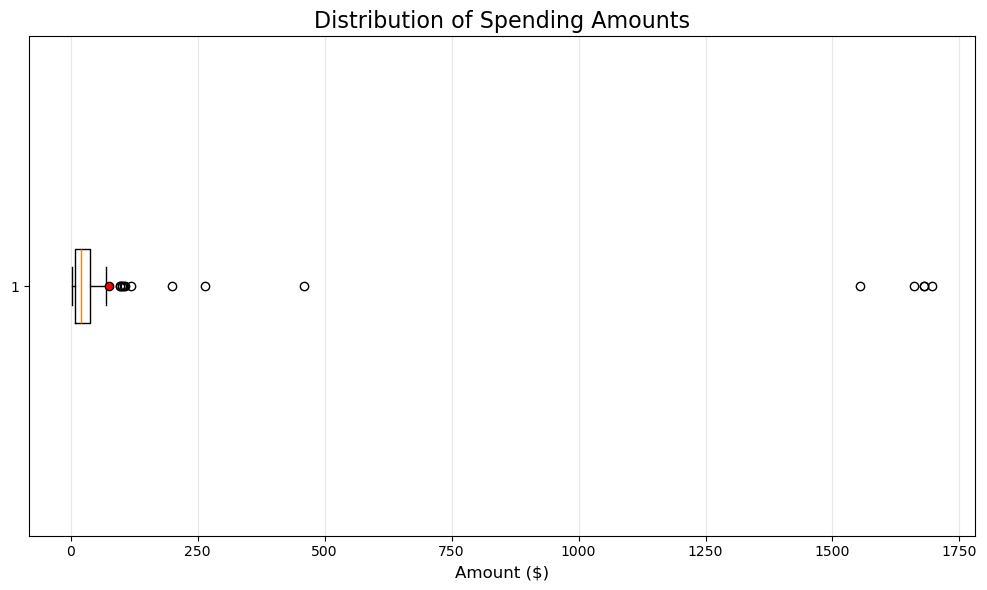

In [6]:
# Get spending statistics
spending_stats = get_spending_statistics(bank_data)

# Overall spending distribution
plot_spending_distribution(bank_data)

### Summary Statistics

I calculated several key summary statistics to quantify my spending patterns:

In [7]:
print("An overview of my spending:")
print(f"Average transaction: ${spending_stats["average"]:.2f}")
print(f"Median transaction: ${spending_stats["median"]:.2f}")
print(f"Largest purchase: ${spending_stats["max"]:.2f}")
print(f"Smallest purchase: ${spending_stats["min"]:.2f}")
print(f"Total spent: ${spending_stats["total"]:.2f}")

An overview of my spending:
Average transaction: $75.21
Median transaction: $20.00
Largest purchase: $1695.63
Smallest purchase: $1.75
Total spent: $13387.45


These statistics provide a quantitative foundation for understanding my financial behavior. The disparity between my mean and median transaction amounts indicates that my spending is right-skewed, with a few large transactions (like my rent payments) pulling the average higher than the median. This suggests that my "average" transaction is actually much smaller than what the mean indicates.

### Visualizations

I created several visualizations to explore different aspects of my spending behavior:

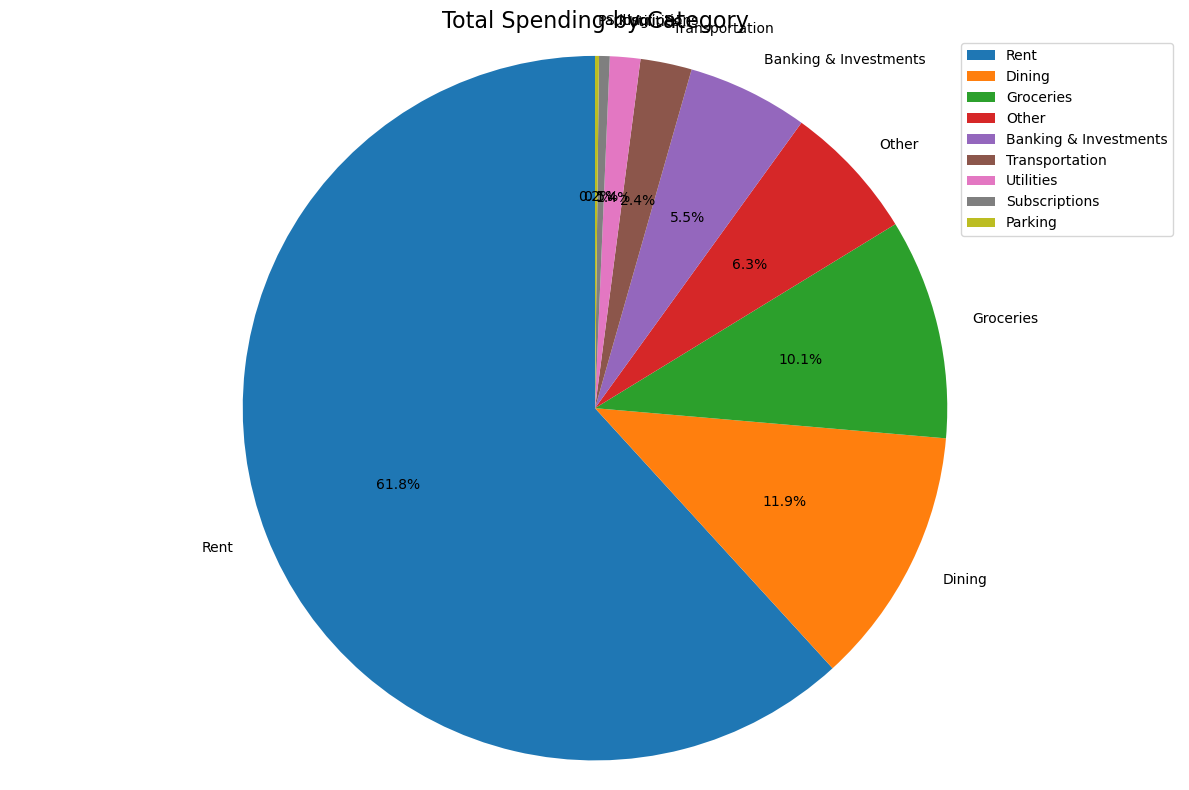

My top 5 spending categories:
Rent: $8270.72
Dining: $1587.03
Groceries: $1353.96
Other: $841.60
Banking & Investments: $742.00


In [8]:
# Let's see which categories I spent the most on
plot_spending_by_category(bank_data)

# Get exact numbers for top 5 categories
top_5_categories = spending_stats["top_categories"].head()
print("My top 5 spending categories:")
for category, amount in top_5_categories.items():
    print(f"{category}: ${amount:.2f}")

This bar chart shows total spending by category, making it clear that rent dominates my expenses, which is pretty expected, followed by dining and groceries. This visualization highlights areas where I might be able to reduce spending, particularly in the dining category.

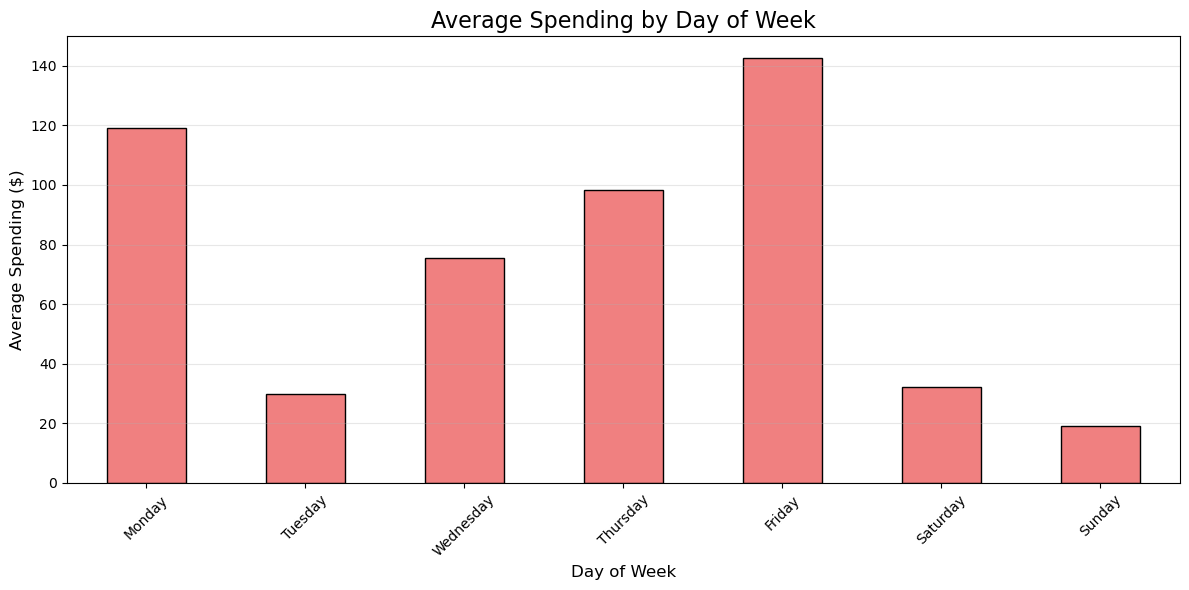

My most expensive day: Friday ($142.73 average)
My cheapest day: Sunday ($19.03 average)


In [9]:
# Let's see if certain days of the week are more expensive than others
plot_spending_by_day(bank_data)

# Find the most and least expensive days
daily_avg = spending_stats["daily_avg"]
print(f"My most expensive day: {daily_avg.idxmax()} (${daily_avg.max():.2f} average)")
print(f"My cheapest day: {daily_avg.idxmin()} (${daily_avg.min():.2f} average)")

This visualization reveals that my spending is not the same throughout the week, not even close! Friday stands out as my highest-spending day, likely because that is the day I go out the most on. Sunday shows the lowest average spending, which makes sense because I normally just stay home and chill on Sundays.

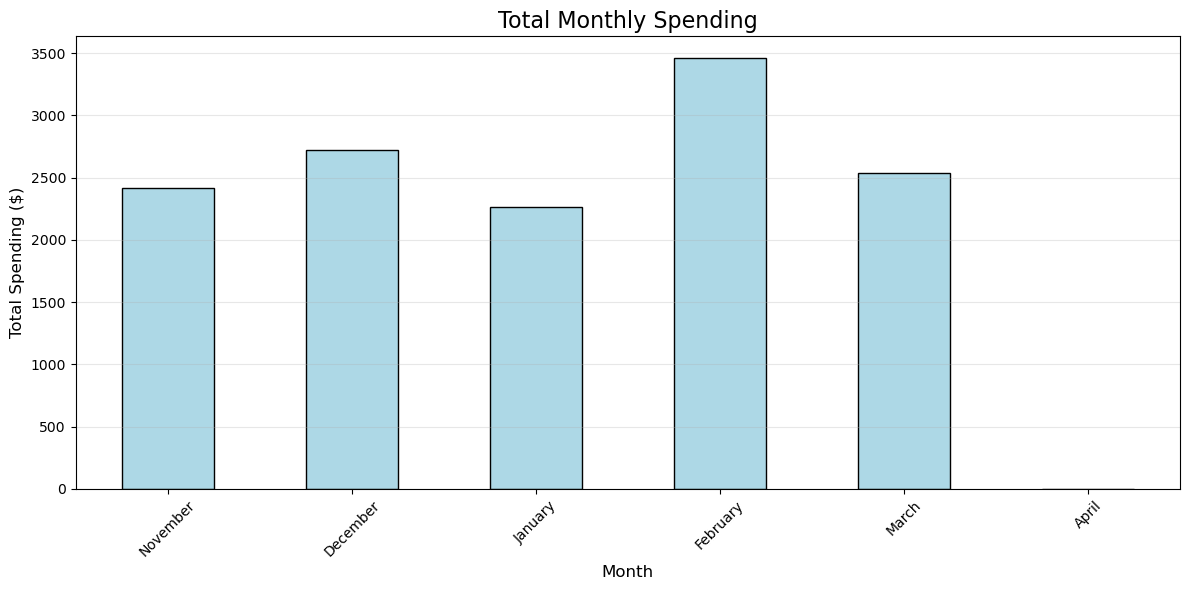

In [10]:
# Monthly trends
monthly_spending = plot_monthly_spending(bank_data)

The monthly trend chart shows significant variation throughout the academic year. February stands out with higher spending most likely due to Valentine's day and going out with my girlfriend. We also see a spike in December likely due to the holidays and then a drop in January possibly reflecting post-holiday budget constraints. There is no spending in April because my data spans to April 1st and my only transaction that day was depositing my paycheck.

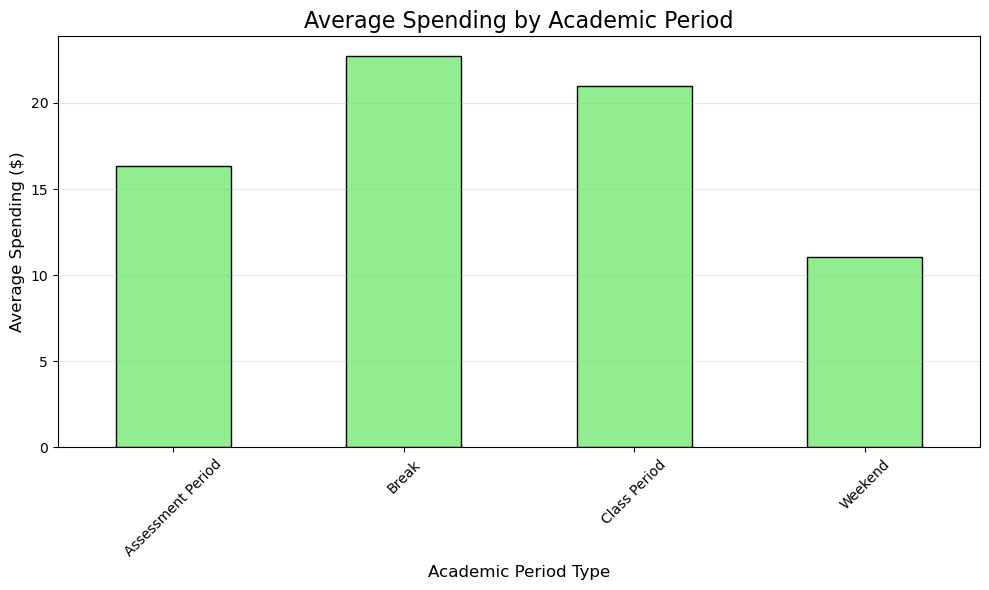

How my spending varies by academic period:


,mean,median,count,sum
period_type,,,,
Break,75.926750,22.725,40,3037.07
Class Period,126.548529,20.975,68,8605.30
Assessment Period,28.055769,16.345,26,729.45
Weekend,23.082500,11.045,44,1015.63



Category breakdown by academic period:


Category,Banking & Investments,Dining,Groceries,Other,Parking,Rent,Subscriptions,Transportation,Utilities
period_type,,,,,,,,,
Assessment Period,263.0,155.95,127.28,161.38,0.00,0.00,21.84,0.00,0.00
Break,55.0,525.74,223.56,322.73,17.12,1680.12,21.84,55.97,134.99
Class Period,419.0,544.86,594.82,211.66,5.00,6590.60,21.84,165.73,51.79
Weekend,5.0,360.48,408.30,145.83,2.05,0.00,0.00,93.97,0.00


In [11]:
# Analyze spending across academic periods
plot_spending_by_period(merged_data)

# Get detailed stats
period_stats, period_category = get_period_spending_statistics(merged_data)

print("How my spending varies by academic period:")
display(period_stats.sort_values(by="median", ascending=False))

print("\nCategory breakdown by academic period:")
display(period_category)

This visualization addresses my central research question by showing how spending varies across different academic contexts. Interestingly, my median transaction amount is highest during Breaks, then Class Period, next Assessment Period, and lastly Weekend. I chose to go with the median due to the fact that most of my data is during the "Class Period". Therefore making it more likely that my large purchases, like rent, would be under that category so I wanted to make the data less skewed. The results do make sense though, I stay in a lot during the weekends so I spend less money and while I'm on break I'm usually back home going out with friends.

## **4. Statistical Hypothesis Testing**

### Hypothesis Test 1: Weekend vs Weekday Spending

$H_0: \mu_{weekend} = \mu_{weekday}$ (Weekend spending equals weekday spending)

$H_1: \mu_{weekend} \neq \mu_{weekday}$ (Weekend spending differs from weekday spending)

Significance Level: $\alpha = 0.05$

## **5. Classification Results**

## **Conclusion**

Sources:

https://www.programiz.com/python-programming/datetime/strftime